## Problem To be Addressed
1. team typically gets 200 loan applications per week and approves them by hand
2. sudden influx of new people applying for loans (nearly 500 loan applications to process this week)
3. manager wants to figure out how to process all of these loan applications within one week

## Obejective
provide a list of creditworthy customers to manager in the next two days

## Available Information
1.	Data on all past applications
2.	The list of customers that need to be processed in the next few days

## Steps
1. Business and Data Understanding
2. Explore and Cleanup the Data
3. Train Classification Models:
- Naive Bayes
- Logistic Regression
- K-NearestNeighbors
- Support Vector Classifier
4. Writeup<br><br>
    Compare all of the models’ performance against each other. Decide on the best model and score your new customers. 



## Solution steps


#       Step 1 : Importing the libraries                      #

In [1]:
import numpy as np
import pandas as pd9
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bioinfokit.analys import stat
import sklearn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns',None)



In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [4]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score


#      Step 2 : Importing the Dataset

In [191]:
train = pd.read_excel("credit-data-training.xlsx")
test = pd.read_excel("customers-to-score.xlsx")

In [192]:
summary={'dataset':['train', 'test'],
       'rows': [train.shape[0], test.shape[0]],
       'columns': [train.shape[1], test.shape[1]]}
pd.DataFrame(summary).set_index('dataset')

,rows,columns
dataset,,
train,500,20
test,500,19


## 3. Exploratory Data Analysis (EDA)

In [193]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Credit-Application-Result          500 non-null    object 
 1   Account-Balance                    500 non-null    object 
 2   Duration-of-Credit-Month           500 non-null    int64  
 3   Payment-Status-of-Previous-Credit  500 non-null    object 
 4   Purpose                            500 non-null    object 
 5   Credit-Amount                      500 non-null    int64  
 6   Value-Savings-Stocks               500 non-null    object 
 7   Length-of-current-employment       500 non-null    object 
 8   Instalment-per-cent                500 non-null    int64  
 9   Guarantors                         500 non-null    object 
 10  Duration-in-Current-address        156 non-null    float64
 11  Most-valuable-available-asset      500 non-null    int64  

In [194]:
#Identifying missing values
train.isnull().sum()

Credit-Application-Result              0
Account-Balance                        0
Duration-of-Credit-Month               0
Payment-Status-of-Previous-Credit      0
Purpose                                0
Credit-Amount                          0
Value-Savings-Stocks                   0
Length-of-current-employment           0
Instalment-per-cent                    0
Guarantors                             0
Duration-in-Current-address          344
Most-valuable-available-asset          0
Age-years                             12
Concurrent-Credits                     0
Type-of-apartment                      0
No-of-Credits-at-this-Bank             0
Occupation                             0
No-of-dependents                       0
Telephone                              0
Foreign-Worker                         0
dtype: int64

In [195]:
#percentage of missing values
print(train.isnull().sum()/len(train) * 100, '\n','='*75)


Credit-Application-Result             0.0
Account-Balance                       0.0
Duration-of-Credit-Month              0.0
Payment-Status-of-Previous-Credit     0.0
Purpose                               0.0
Credit-Amount                         0.0
Value-Savings-Stocks                  0.0
Length-of-current-employment          0.0
Instalment-per-cent                   0.0
Guarantors                            0.0
Duration-in-Current-address          68.8
Most-valuable-available-asset         0.0
Age-years                             2.4
Concurrent-Credits                    0.0
Type-of-apartment                     0.0
No-of-Credits-at-this-Bank            0.0
Occupation                            0.0
No-of-dependents                      0.0
Telephone                             0.0
Foreign-Worker                        0.0
dtype: float64 


- About 69% of the data in Duration-in-Current-address is missing and thereforre needs to be eliminated
- The missing values in Age-years is just 2.4% which is almost insignificant. These missing values would be replaced by median of Age-years

### **Separating data into numeric and categorical for detail inspections**

In [196]:
numeric_train = train.select_dtypes(include=np.number)
categorical_train = train.select_dtypes(include='object')
categorical_test = test.select_dtypes(include='object')


In [197]:
#Number of numeric and categorical variables

print('numeric variables: {}\n categorical variables: {}'\
      .format(numeric_train.shape[1], categorical_train.shape[1]))

numeric variables: 11
 categorical variables: 9


#### Exploring categorical variables

In [198]:
for i in categorical_train.columns:
    print(i)

Credit-Application-Result
Account-Balance
Payment-Status-of-Previous-Credit
Purpose
Value-Savings-Stocks
Length-of-current-employment
Guarantors
Concurrent-Credits
No-of-Credits-at-this-Bank


In [199]:
def explore_categorical(df, col):
    df=df[col]
    df.nunique()
    print('Summary:\n',col)
    print('-'*27)
    sns.countplot(df)
    plt.show()
    print('\n',df.describe(),'\n')

    print('value counts (%):')
    print('-'*12)
    print(df.value_counts()/len(df)*100)
    print ('\nMissing values (%): ')
    print('-'*12)
    print (df.isnull().sum()/len(df) * 100,)

    print('='*65,'\n\n')


    

### Compare the number of categories in each columns for both training and testing data

In [200]:
def count_categories(df):
    for i in df.columns:
        print(i,':',df[i].nunique())

In [201]:
count_categories(categorical_train)

Credit-Application-Result : 2
Account-Balance : 2
Payment-Status-of-Previous-Credit : 3
Purpose : 4
Value-Savings-Stocks : 3
Length-of-current-employment : 3
Guarantors : 2
Concurrent-Credits : 1
No-of-Credits-at-this-Bank : 2


In [202]:

count_categories(categorical_test)

Account-Balance : 2
Payment-Status-of-Previous-Credit : 3
Purpose : 3
Value-Savings-Stocks : 3
Length-of-current-employment : 3
Guarantors : 2
Concurrent-Credits : 1
No-of-Credits-at-this-Bank : 2


- Purpose in training has more categories than in test
- To solve this, new and old cars are categorised as other

In [203]:
#Replace Used and New car with Other in categorical_train data
categorical_train['Purpose'].replace({'Used car':'Other', 'New car':'Other'}, inplace=True)

In [204]:
#Replace Used and New car with Other in train data
train['Purpose'].replace({'Used car':'Other', 'New car':'Other'}, inplace=True)

In [205]:
test['Purpose'].value_counts()

Home Related    354
Used car         94
New car          52
Name: Purpose, dtype: int64

In [206]:
#Replace Used and New car with Other in test data
test['Purpose'].replace({'Used car':'Other', 'New car':'Other'}, inplace=True)

Summary:
 Credit-Application-Result
---------------------------


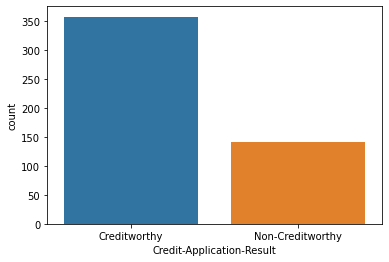


 count              500
unique               2
top       Creditworthy
freq               358
Name: Credit-Application-Result, dtype: object 

value counts (%):
------------
Creditworthy        71.6
Non-Creditworthy    28.4
Name: Credit-Application-Result, dtype: float64

Missing values (%): 
------------
0.0


Summary:
 Account-Balance
---------------------------


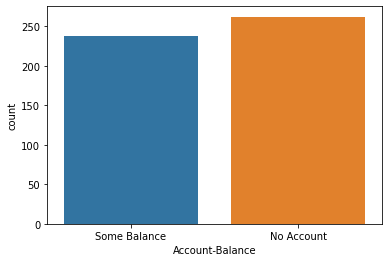


 count            500
unique             2
top       No Account
freq             262
Name: Account-Balance, dtype: object 

value counts (%):
------------
No Account      52.4
Some Balance    47.6
Name: Account-Balance, dtype: float64

Missing values (%): 
------------
0.0


Summary:
 Payment-Status-of-Previous-Credit
---------------------------


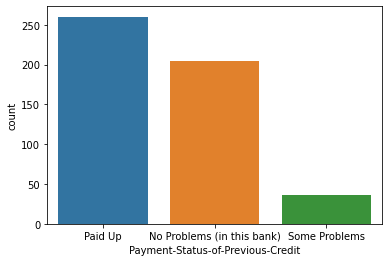


 count         500
unique          3
top       Paid Up
freq          260
Name: Payment-Status-of-Previous-Credit, dtype: object 

value counts (%):
------------
Paid Up                       52.0
No Problems (in this bank)    40.8
Some Problems                  7.2
Name: Payment-Status-of-Previous-Credit, dtype: float64

Missing values (%): 
------------
0.0


Summary:
 Purpose
---------------------------


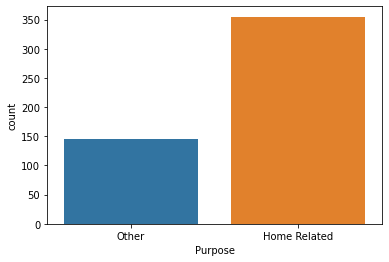


 count              500
unique               2
top       Home Related
freq               355
Name: Purpose, dtype: object 

value counts (%):
------------
Home Related    71.0
Other           29.0
Name: Purpose, dtype: float64

Missing values (%): 
------------
0.0


Summary:
 Value-Savings-Stocks
---------------------------


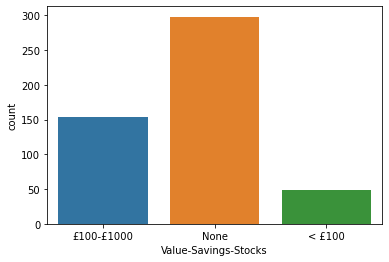


 count      500
unique       3
top       None
freq       298
Name: Value-Savings-Stocks, dtype: object 

value counts (%):
------------
None          59.6
£100-£1000    30.8
< £100         9.6
Name: Value-Savings-Stocks, dtype: float64

Missing values (%): 
------------
0.0


Summary:
 Length-of-current-employment
---------------------------


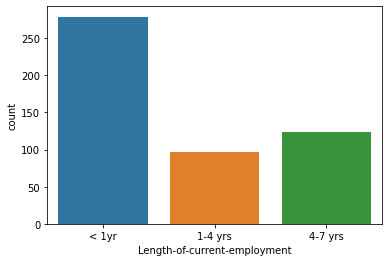


 count       500
unique        3
top       < 1yr
freq        279
Name: Length-of-current-employment, dtype: object 

value counts (%):
------------
< 1yr      55.8
4-7 yrs    24.8
1-4 yrs    19.4
Name: Length-of-current-employment, dtype: float64

Missing values (%): 
------------
0.0


Summary:
 Guarantors
---------------------------


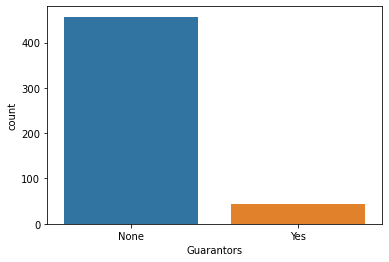


 count      500
unique       2
top       None
freq       457
Name: Guarantors, dtype: object 

value counts (%):
------------
None    91.4
Yes      8.6
Name: Guarantors, dtype: float64

Missing values (%): 
------------
0.0


Summary:
 Concurrent-Credits
---------------------------


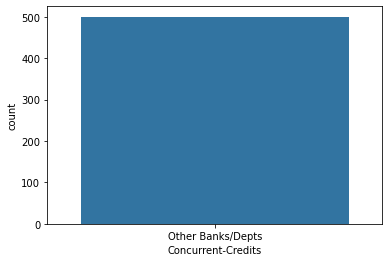


 count                   500
unique                    1
top       Other Banks/Depts
freq                    500
Name: Concurrent-Credits, dtype: object 

value counts (%):
------------
Other Banks/Depts    100.0
Name: Concurrent-Credits, dtype: float64

Missing values (%): 
------------
0.0


Summary:
 No-of-Credits-at-this-Bank
---------------------------


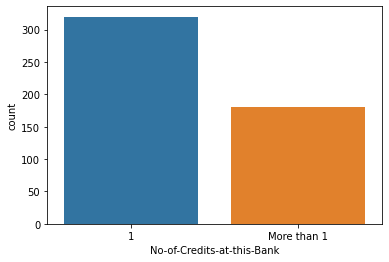


 count     500
unique      2
top         1
freq      320
Name: No-of-Credits-at-this-Bank, dtype: object 

value counts (%):
------------
1              64.0
More than 1    36.0
Name: No-of-Credits-at-this-Bank, dtype: float64

Missing values (%): 
------------
0.0




In [207]:
for i in categorical_train.columns:
    explore_categorical(categorical_train, i)

1. **Credit-Application-Result** (label variable)
- Has two unique categories
- Creditworthy appears most making the data unbalanced. This could result into the predictions being skewed towards Creditworthy, indicating that more customers are likely to be given the loan. 
- There is no missing value
2. **Account-Balance** (maintain)
- 2 categories with no missing value
3. **Payment-Status-of-Previous-Credit** (maintain)
- 3 categories with no missing value
4. **Purpose** (maintain)
- 2 categories with no missing value
5. **Value-Savings-Stocks** (maintain)
- 3 categories with no missing value
6. **Length-of-current-employment** (maintain)
- 3 categories with no missing value
7. **Guarantors** (drop)
- 2 categories with no missing value
- not balanced and almost not uniform. about 98% do not have guarantors. Not possible to contribute to credit worthiness determination
8. **Concurrent-Credits** (drop)
- one unique value
- not possible to determine credit worthiness

In [208]:
#Credit-Application-Result vs other categorical variables

col = ['Account-Balance','Payment-Status-of-Previous-Credit',
       'Purpose','Value-Savings-Stocks','Length-of-current-employment']
for i in col:
    print (pd.crosstab(categorical_train[i], categorical_train['Credit-Application-Result']))
    print('='*65)

Credit-Application-Result  Creditworthy  Non-Creditworthy
Account-Balance                                          
No Account                          152               110
Some Balance                        206                32
Credit-Application-Result          Creditworthy  Non-Creditworthy
Payment-Status-of-Previous-Credit                                
No Problems (in this bank)                  162                42
Paid Up                                     185                75
Some Problems                                11                25
Credit-Application-Result  Creditworthy  Non-Creditworthy
Purpose                                                  
Home Related                        244               111
Other                               114                31
Credit-Application-Result  Creditworthy  Non-Creditworthy
Value-Savings-Stocks                                     
< £100                               36                12
None                            

1. The probility of a customer with some balance being credit worthy is higher than those with no account balance
2. On average, those who have some problems with the bank are usually Non-Creditworthy.
3. majority of customers borrow money for home related purposes, and have lowest chance of being considered credit worthy than  Other purpose 
4. Customers with Value-Savings-Stocks of £100-£1000 have highest chance of being creditworthy. 
5. majority of the customers who spent < 1yr at their current employment. However, those who have spent 1-4 yrs at their current employment have highest chance of being credit worthy 


#### Exploring Relationship among categorical variables

In [209]:
def testing_cat(data, i, j):
    table = pd.crosstab(data[i], data[j])
    test = stat()
    test.chisq(table)
    print('\nResults:')
    print('='*65)
    print(table)
    print('-'*65)
    print(test.expected_df)
    print('='*65)
    print(test.summary)


In [210]:
#1. 'Credit-Application-Result' and 'Account-Balance'
testing_cat(train, 'Credit-Application-Result', 'Account-Balance')



Results:
Account-Balance            No Account  Some Balance
Credit-Application-Result                          
Creditworthy                      152           206
Non-Creditworthy                  110            32
-----------------------------------------------------------------

Expected frequency counts

      No Account    Some Balance
--  ------------  --------------
 0       187.592         170.408
 1        74.408          67.592


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            1       48.5598  3.20374e-12
Log-likelihood     1       50.8098  1.01762e-12



We fail to accept the hypothesis that **'Credit-Application-Result'** and **'Account-Balance'** are independent since the p-value < 0.05

In [211]:
#2. 'Credit-Application-Result' and 'Account-Balance'
testing_cat(train, 'Credit-Application-Result', 'Payment-Status-of-Previous-Credit')



Results:
Payment-Status-of-Previous-Credit  No Problems (in this bank)  Paid Up  \
Credit-Application-Result                                                
Creditworthy                                              162      185   
Non-Creditworthy                                           42       75   

Payment-Status-of-Previous-Credit  Some Problems  
Credit-Application-Result                         
Creditworthy                                  11  
Non-Creditworthy                              25  
-----------------------------------------------------------------

Expected frequency counts

      No Problems (in this bank)    Paid Up    Some Problems
--  ----------------------------  ---------  ---------------
 0                       146.064     186.16           25.776
 1                        57.936      73.84           10.224


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson           

We fail to accept the hypothesis that **'Credit-Application-Result'** and **'Payment-Status-of-Previous-Credit'** are independent since the p-value < 0.05

In [212]:
#3. 'Credit-Application-Result' and 'Purpose'
testing_cat(train, 'Credit-Application-Result', 'Purpose')



Results:
Purpose                    Home Related  Other
Credit-Application-Result                     
Creditworthy                        244    114
Non-Creditworthy                    111     31
-----------------------------------------------------------------

Expected frequency counts

      Home Related    Other
--  --------------  -------
 0          254.18   103.82
 1          100.82    41.18


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            1       4.47603  0.0343735
Log-likelihood     1       4.62836  0.0314477



Fail to reject the hypothesis that **'Credit-Application-Result'** and **'Purpose'** are independent since the p-value < 0.05. <br><br>


In [213]:
#4. 'Credit-Application-Result' and 'Value-Savings-Stocks'
testing_cat(train, 'Credit-Application-Result', 'Value-Savings-Stocks')


Results:
Value-Savings-Stocks       < £100  None  £100-£1000
Credit-Application-Result                          
Creditworthy                   36   195         127
Non-Creditworthy               12   103          27
-----------------------------------------------------------------

Expected frequency counts

      < £100     None    £100-£1000
--  --------  -------  ------------
 0    34.368  213.368       110.264
 1    13.632   84.632        43.736


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            2        14.785  0.00061586
Log-likelihood     2        15.481  0.000434851



We fail to accept the hypothesis that **'Credit-Application-Result'** and **'Value-Savings-Stocks'** are independent since the p-value < 0.05

In [214]:
#5. 'Credit-Application-Result' and 'Length-of-current-employment'
testing_cat(train, 'Credit-Application-Result', 'Length-of-current-employment')


Results:
Length-of-current-employment  1-4 yrs  4-7 yrs  < 1yr
Credit-Application-Result                            
Creditworthy                       76       94    188
Non-Creditworthy                   21       30     91
-----------------------------------------------------------------

Expected frequency counts

      1-4 yrs    4-7 yrs    < 1yr
--  ---------  ---------  -------
 0     69.452     88.784  199.764
 1     27.548     35.216   79.236


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            2       5.69213  0.0580725
Log-likelihood     2       5.78294  0.0554945



Though We failed to reject the hypothesis that **'Credit-Application-Result'** and **'Length-of-current-employment'** are independent since the p-value > 0.05,  <br><br>
**Length-of-current-employment (is maintained)**

In [215]:
#Drop the following categorical variables in both train and test:
#1. Guarantors
#2. Concurrent-Credits


In [216]:
categorical_train = categorical_train.drop(columns=['Guarantors', 'Concurrent-Credits'])

In [217]:
train = train.drop(columns=['Guarantors', 'Concurrent-Credits'])


In [218]:
test = test.drop(columns=['Guarantors', 'Concurrent-Credits'])


#### Exploring Numerical variables

In [219]:
numeric_train.head()

,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Duration-in-Current-address,Most-valuable-available-asset,Age-years,Type-of-apartment,Occupation,No-of-dependents,Telephone,Foreign-Worker
0,4,1494,1,2.0,1,NaN,2,1,2,1,2
1,4,1494,1,2.0,1,29.0,2,1,2,1,2
2,4,1544,2,1.0,1,42.0,2,1,2,1,1
3,4,3380,1,1.0,1,37.0,2,1,2,1,1
4,6,343,4,1.0,1,27.0,2,1,1,1,1


**feature addition:**
- Credit-Amount-per-dependant = credit-Amount / No-of-dependents
This is is a useful information that could determine how a customer is likely to be credit worthy

In [220]:
def numeric_var_explore(df, i):
    print ("Summary:")
    print('-'*65)
    print(df[i].describe())
    print('-'*65)
    print("Missing values: {}".format(df[i].isnull().sum()))
    #Fill missing value with median if not zero
    

    #Histogram
    plt.subplot(1,2,1)
    plt.hist(df[i])

    plt.title('Histogram')
    
    #Boxplot of numeric variables
    plt.figsize=(5,5)
    plt.subplot(1,2,2)
    plt.boxplot(df[i], vert=True, patch_artist=True, notch=True, showmeans=True)
    plt.xlabel(df[i].name)
    plt.title('Boxplot')
    plt.tight_layout()

    plt.show()

Summary:
-----------------------------------------------------------------
count    500.00000
mean      21.43400
std       12.30742
min        4.00000
25%       12.00000
50%       18.00000
75%       24.00000
max       60.00000
Name: Duration-of-Credit-Month, dtype: float64
-----------------------------------------------------------------
Missing values: 0


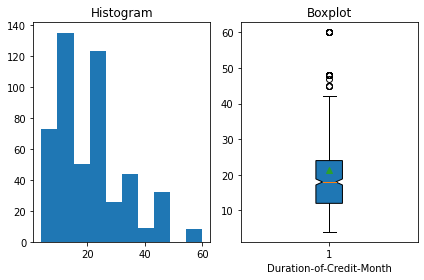

Summary:
-----------------------------------------------------------------
count      500.000000
mean      3199.980000
std       2831.386861
min        276.000000
25%       1357.250000
50%       2236.500000
75%       3941.500000
max      18424.000000
Name: Credit-Amount, dtype: float64
-----------------------------------------------------------------
Missing values: 0


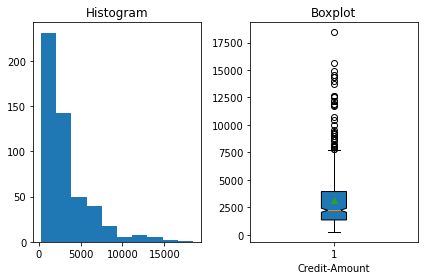

Summary:
-----------------------------------------------------------------
count    500.000000
mean       3.010000
std        1.113724
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Instalment-per-cent, dtype: float64
-----------------------------------------------------------------
Missing values: 0


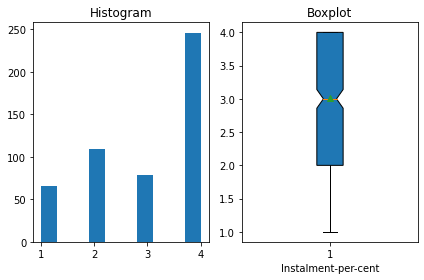

Summary:
-----------------------------------------------------------------
count    156.000000
mean       2.660256
std        1.150017
min        1.000000
25%        2.000000
50%        2.000000
75%        4.000000
max        4.000000
Name: Duration-in-Current-address, dtype: float64
-----------------------------------------------------------------
Missing values: 344


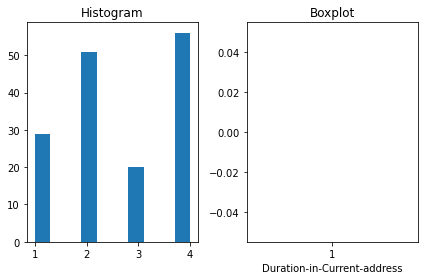

Summary:
-----------------------------------------------------------------
count    500.000000
mean       2.360000
std        1.064268
min        1.000000
25%        1.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Most-valuable-available-asset, dtype: float64
-----------------------------------------------------------------
Missing values: 0


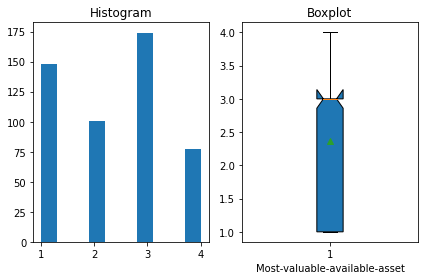

Summary:
-----------------------------------------------------------------
count    488.000000
mean      35.637295
std       11.501522
min       19.000000
25%       27.000000
50%       33.000000
75%       42.000000
max       75.000000
Name: Age-years, dtype: float64
-----------------------------------------------------------------
Missing values: 12


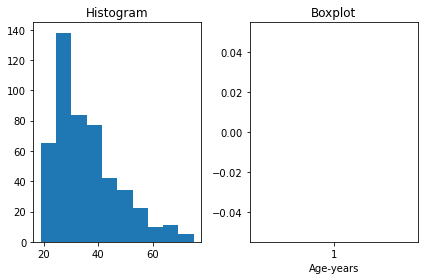

Summary:
-----------------------------------------------------------------
count    500.000000
mean       1.928000
std        0.539814
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: Type-of-apartment, dtype: float64
-----------------------------------------------------------------
Missing values: 0


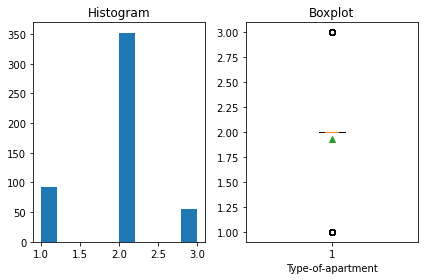

Summary:
-----------------------------------------------------------------
count    500.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Occupation, dtype: float64
-----------------------------------------------------------------
Missing values: 0


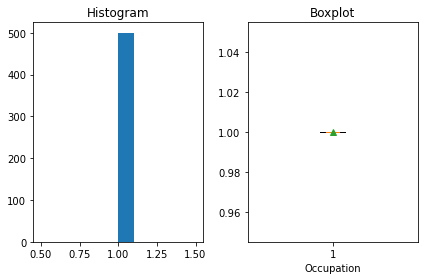

Summary:
-----------------------------------------------------------------
count    500.00000
mean       1.14600
std        0.35346
min        1.00000
25%        1.00000
50%        1.00000
75%        1.00000
max        2.00000
Name: No-of-dependents, dtype: float64
-----------------------------------------------------------------
Missing values: 0


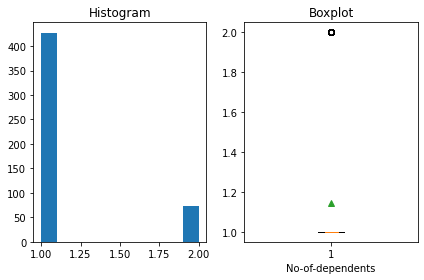

Summary:
-----------------------------------------------------------------
count    500.000000
mean       1.400000
std        0.490389
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: Telephone, dtype: float64
-----------------------------------------------------------------
Missing values: 0


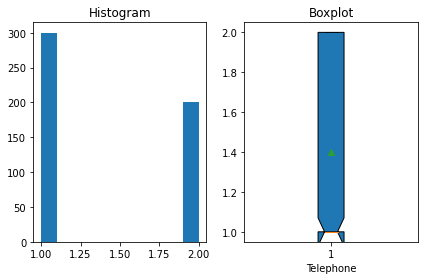

Summary:
-----------------------------------------------------------------
count    500.000000
mean       1.038000
std        0.191388
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: Foreign-Worker, dtype: float64
-----------------------------------------------------------------
Missing values: 0


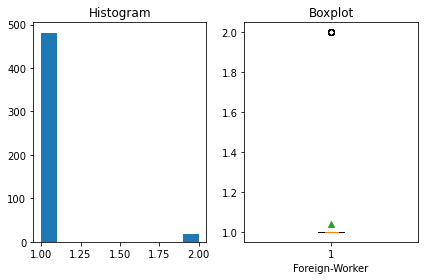

In [221]:
for i in numeric_train.columns:
    numeric_var_explore(numeric_train,i)

**Drop:**
- Duration-in-Current-address (lot of missing values)
- Occupation (Single vaue causing uniformity)
- Foriegn worker (low variance)

**replace Missing values**
- Age-years

#### Correlation among the numeric variables

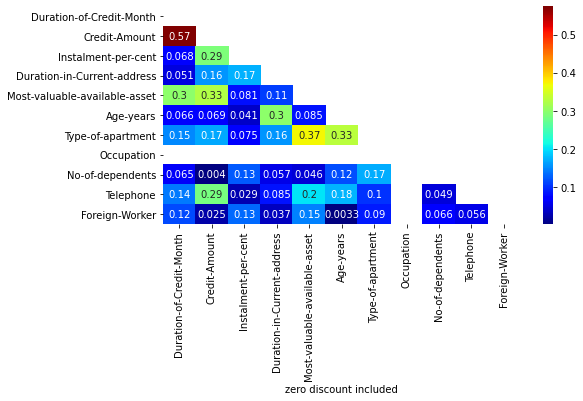

In [222]:

corr = numeric_train.corr().abs()
matrix = np.triu(corr)
plt.figure(figsize = [8, 4])
sns.heatmap(corr,annot = True, cmap='jet', mask=matrix) #zero discount included
plt.xlabel('zero discount included')

plt.show()

Non of the correlations exceed 0.70. Occupation still needs to be dropped

In [223]:
# replacing missing values in Age-years
numeric_train['Age-years'].isnull().sum()

12

In [224]:
median = numeric_train['Age-years'].median()
train['Age-years'] = train['Age-years'].fillna(median)

train['Age-years'].isnull().sum()

0

In [225]:
test['Age-years'].isnull().sum()

0

In [226]:
#Deop the following numeric variables in train and test
#1. Duration-in-Current-address 
#2. Occupation 
#3. Foriegn worker 

In [227]:
numeric_train = numeric_train.drop(columns=['Duration-in-Current-address', 'Occupation', 'Foreign-Worker'])

In [228]:
train = train.drop(columns=['Duration-in-Current-address', 'Occupation', 'Foreign-Worker'])


In [229]:
test = test.drop(columns=['Duration-in-Current-address', 'Occupation', 'Foreign-Worker'])


In [230]:
#Final inspection of categorical and numerical variables

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Credit-Application-Result          500 non-null    object 
 1   Account-Balance                    500 non-null    object 
 2   Duration-of-Credit-Month           500 non-null    int64  
 3   Payment-Status-of-Previous-Credit  500 non-null    object 
 4   Purpose                            500 non-null    object 
 5   Credit-Amount                      500 non-null    int64  
 6   Value-Savings-Stocks               500 non-null    object 
 7   Length-of-current-employment       500 non-null    object 
 8   Instalment-per-cent                500 non-null    int64  
 9   Most-valuable-available-asset      500 non-null    int64  
 10  Age-years                          500 non-null    float64
 11  Type-of-apartment                  500 non-null    int64  

In [231]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Account-Balance                    500 non-null    object
 1   Duration-of-Credit-Month           500 non-null    int64 
 2   Payment-Status-of-Previous-Credit  500 non-null    object
 3   Purpose                            500 non-null    object
 4   Credit-Amount                      500 non-null    int64 
 5   Value-Savings-Stocks               500 non-null    object
 6   Length-of-current-employment       500 non-null    object
 7   Instalment-per-cent                500 non-null    int64 
 8   Most-valuable-available-asset      500 non-null    int64 
 9   Age-years                          500 non-null    int64 
 10  Type-of-apartment                  500 non-null    int64 
 11  No-of-Credits-at-this-Bank         500 non-null    object
 12  No-of-de

## Data Preprocessing 

1. Encoding Categorical variables


In [232]:
#label encoding target variable

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train['Credit-Application-Result']=le.fit_transform(train['Credit-Application-Result']) 
train

,Credit-Application-Result,Account-Balance,Duration-of-Credit-Month,Payment-Status-of-Previous-Credit,Purpose,Credit-Amount,Value-Savings-Stocks,Length-of-current-employment,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,No-of-Credits-at-this-Bank,No-of-dependents,Telephone
0,0,Some Balance,4,Paid Up,Other,1494,£100-£1000,< 1yr,1,1,33.0,2,1,2,1
1,0,Some Balance,4,Paid Up,Home Related,1494,£100-£1000,< 1yr,1,1,29.0,2,1,2,1
2,0,Some Balance,4,No Problems (in this bank),Home Related,1544,None,1-4 yrs,2,1,42.0,2,More than 1,2,1
3,0,Some Balance,4,No Problems (in this bank),Home Related,3380,None,1-4 yrs,1,1,37.0,2,1,2,1
4,0,No Account,6,Paid Up,Home Related,343,None,< 1yr,4,1,27.0,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,No Account,60,No Problems (in this bank),Other,7418,£100-£1000,< 1yr,1,1,33.0,2,1,1,1
496,0,No Account,60,No Problems (in this bank),Home Related,7418,£100-£1000,< 1yr,1,1,27.0,2,1,1,1
497,0,No Account,60,No Problems (in this bank),Home Related,9157,£100-£1000,< 1yr,2,4,27.0,3,1,1,1
498,0,Some Balance,60,No Problems (in this bank),Home Related,13756,£100-£1000,4-7 yrs,2,4,63.0,3,1,1,2


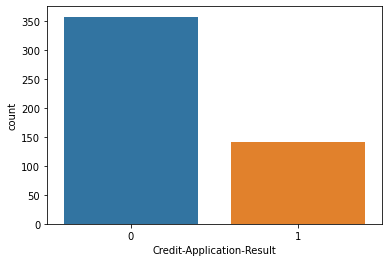

In [233]:
#Inspect target variable after encoding
sns.countplot(train['Credit-Application-Result'])
plt.show()

**0 = Creditworthy, 1 = Non-creditworthy**

In [234]:
categorical_train.head(1)

,Credit-Application-Result,Account-Balance,Payment-Status-of-Previous-Credit,Purpose,Value-Savings-Stocks,Length-of-current-employment,No-of-Credits-at-this-Bank
0,Creditworthy,Some Balance,Paid Up,Other,£100-£1000,< 1yr,1


In [235]:
#convert other categorical variables using get_dummies

train = pd.get_dummies(train, columns=['Account-Balance', 'Payment-Status-of-Previous-Credit', 'Purpose',
                                       'Value-Savings-Stocks', 'Length-of-current-employment', 'No-of-Credits-at-this-Bank'], drop_first=True)


In [236]:
test = pd.get_dummies(test, columns=['Account-Balance', 'Payment-Status-of-Previous-Credit', 'Purpose',
                                       'Value-Savings-Stocks', 'Length-of-current-employment', 'No-of-Credits-at-this-Bank'], drop_first=True)


In [237]:
train.head(1)

,Credit-Application-Result,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,No-of-dependents,Telephone,Account-Balance_Some Balance,Payment-Status-of-Previous-Credit_Paid Up,Payment-Status-of-Previous-Credit_Some Problems,Purpose_Other,Value-Savings-Stocks_None,Value-Savings-Stocks_£100-£1000,Length-of-current-employment_4-7 yrs,Length-of-current-employment_< 1yr,No-of-Credits-at-this-Bank_More than 1
0,0,4,1494,1,1,33.0,2,2,1,1,1,0,1,0,1,0,1,0


In [238]:
test.head(1)

,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,No-of-dependents,Telephone,Account-Balance_Some Balance,Payment-Status-of-Previous-Credit_Paid Up,Payment-Status-of-Previous-Credit_Some Problems,Purpose_Other,Value-Savings-Stocks_None,Value-Savings-Stocks_£100-£1000,Length-of-current-employment_4-7 yrs,Length-of-current-employment_< 1yr,No-of-Credits-at-this-Bank_More than 1
0,9,2799,2,1,36,1,2,1,0,0,0,0,1,0,0,1,1


In [239]:
train.describe()

,Credit-Application-Result,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,No-of-dependents,Telephone,Account-Balance_Some Balance,Payment-Status-of-Previous-Credit_Paid Up,Payment-Status-of-Previous-Credit_Some Problems,Purpose_Other,Value-Savings-Stocks_None,Value-Savings-Stocks_£100-£1000,Length-of-current-employment_4-7 yrs,Length-of-current-employment_< 1yr,No-of-Credits-at-this-Bank_More than 1
count,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.0000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.284000,21.43400,3199.980000,3.010000,2.360000,35.574000,1.928000,1.14600,1.400000,0.476000,0.5200,0.072000,0.290000,0.596000,0.308000,0.248000,0.558000,0.360000
std,0.451388,12.30742,2831.386861,1.113724,1.064268,11.369567,0.539814,0.35346,0.490389,0.499924,0.5001,0.258747,0.454216,0.491189,0.462129,0.432284,0.497122,0.480481
min,0.000000,4.00000,276.000000,1.000000,1.000000,19.000000,1.000000,1.00000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,12.00000,1357.250000,2.000000,1.000000,27.000000,2.000000,1.00000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,18.00000,2236.500000,3.000000,3.000000,33.000000,2.000000,1.00000,1.000000,0.000000,1.0000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,24.00000,3941.500000,4.000000,3.000000,41.000000,2.000000,1.00000,2.000000,1.000000,1.0000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,60.00000,18424.000000,4.000000,4.000000,75.000000,3.000000,2.00000,2.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###  Correlation Inspection

In [240]:
corr_matrix = train.corr().abs()
corr_matrix['Credit-Application-Result'].sort_values(ascending = False)

Credit-Application-Result                          1.000000
Account-Balance_Some Balance                       0.316080
Payment-Status-of-Previous-Credit_Some Problems    0.253531
Duration-of-Credit-Month                           0.202504
Credit-Amount                                      0.201946
Value-Savings-Stocks_None                          0.166021
Value-Savings-Stocks_£100-£1000                    0.160782
Most-valuable-available-asset                      0.141332
Length-of-current-employment_< 1yr                 0.105061
Purpose_Other                                      0.099502
Instalment-per-cent                                0.062107
No-of-Credits-at-this-Bank_More than 1             0.056549
Length-of-current-employment_4-7 yrs               0.053569
Age-years                                          0.052914
No-of-dependents                                   0.041048
Telephone                                          0.028971
Type-of-apartment                       

**feature addition:**

- Credit-Amount-per-age = credit-Amount / Age-years 

This is a useful information that could determine how a customer is likely to be credit worthy based on his/her age. It is being added at this stage to enable me compare its correlatioin with 'Credit-Application-Result' to the correlation of 'credit-Amount' and 'Age-years'  with 'Credit-Application-Result'. 

In [241]:
train['Credit-Amount-per-age'] = train['Credit-Amount']/train['Age-years']

In [242]:
test['Credit-Amount-per-age'] = test['Credit-Amount']/test['Age-years']

### Final Correlation Inspection

In [243]:
corr_matrix = train.corr().abs()
corr_matrix['Credit-Application-Result'].sort_values(ascending = False)

Credit-Application-Result                          1.000000
Account-Balance_Some Balance                       0.316080
Payment-Status-of-Previous-Credit_Some Problems    0.253531
Credit-Amount-per-age                              0.210263
Duration-of-Credit-Month                           0.202504
Credit-Amount                                      0.201946
Value-Savings-Stocks_None                          0.166021
Value-Savings-Stocks_£100-£1000                    0.160782
Most-valuable-available-asset                      0.141332
Length-of-current-employment_< 1yr                 0.105061
Purpose_Other                                      0.099502
Instalment-per-cent                                0.062107
No-of-Credits-at-this-Bank_More than 1             0.056549
Length-of-current-employment_4-7 yrs               0.053569
Age-years                                          0.052914
No-of-dependents                                   0.041048
Telephone                               

##### Final Observations
- **'Credit-Amount-per-age' is having higher correlation with 'Credit-Application-Result' than the correlation between 'Credit-Application-Result' and 'Credit-Amount', and 'Age-years'**
- **'Account-Balance_Some Balance'  has the highest correlation with 'Credit-Application-Result'. 'Payment-Status-of-Previous-Credit_Paid Up', however, showed least correlation with 'Credit-Application-Result'**

In [244]:
#Inspecting Account-Balance_Some Balance and Credit-Application-Result
pd.crosstab(train['Account-Balance_Some Balance'], train['Credit-Application-Result'])


Credit-Application-Result,0,1
Account-Balance_Some Balance,,
0,152,110
1,206,32


**while customers with some account balance (1) stand at a 87% chance of being consideredare considered credit worthy (0), those without some balane (0) stand at only 58% chance of being considered credit worthy (0). Thus, having some account balance gives you high chance of being credit worthy. This could be the reason why 'Account-Balance_Some Balance' has highest correlation with Credit-Application-Result**


In [245]:
#Inspecting Payment-Status-of-Previous-Credit_Paid Up and Credit-Application-Result
pd.crosstab(train['Payment-Status-of-Previous-Credit_Paid Up'], train['Credit-Application-Result'])


Credit-Application-Result,0,1
Payment-Status-of-Previous-Credit_Paid Up,,
0,173,67
1,185,75


**while Customers who previously paid up their credit (1) stand at a 71% chance of being considered credit worthy (0), those who do not pay up previous credit or have some issues (0) also stand at 72% chance of being considered credit worthy (0). They almost have similar chances of getting loans. This could be the reason why 'Payment-Status-of-Previous-Credit_Paid Up' does not have much correlation with Credit-Application-Result**

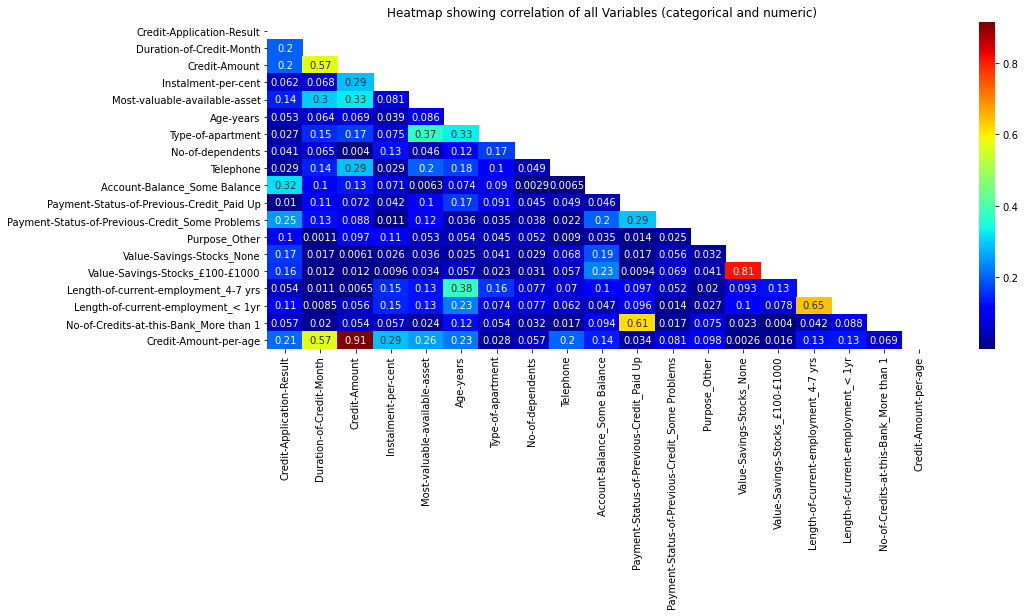

In [246]:
#Heatmap Showing Correlation among variables
corr = train.corr().abs()
matrix = np.triu(corr)
plt.figure(figsize = [15, 6])
sns.heatmap(corr,annot = True, cmap='jet', mask=matrix) #zero discount included
plt.title('Heatmap showing correlation of all Variables (categorical and numeric)')

plt.show()

In [247]:
#Drop Credit-Amount. This is to eliminate the strong correlation with 'Credit-Amount-per-age'
train = train.drop(columns=['Credit-Amount', 'Age-years'])

In [248]:
test = test.drop(columns=['Credit-Amount', 'Age-years'])

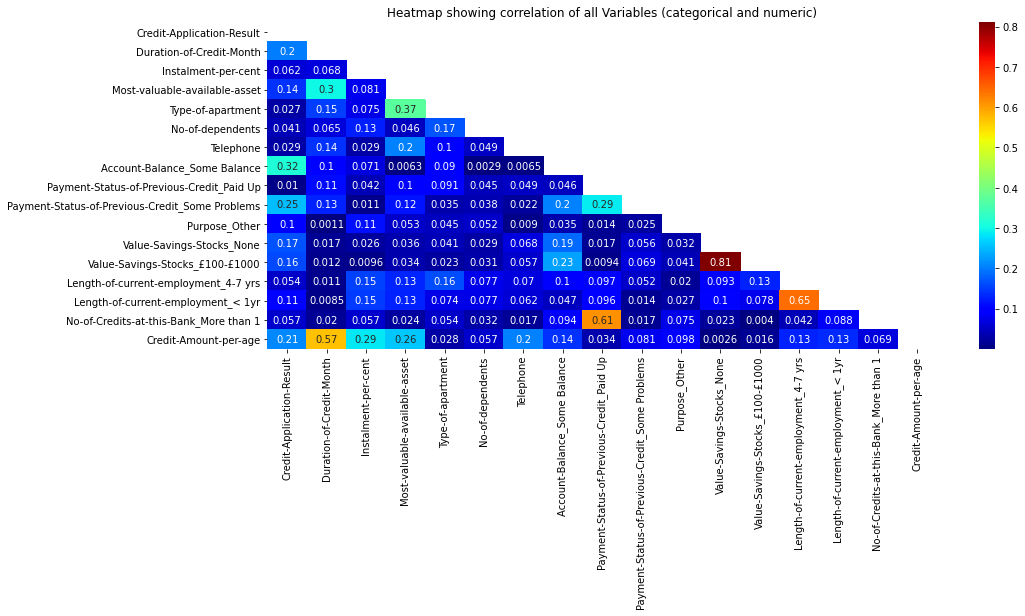

In [249]:
#Heatmap Showing Correlation among variables
corr = train.corr().abs()
matrix = np.triu(corr)
plt.figure(figsize = [15, 6])
sns.heatmap(corr,annot = True, cmap='jet', mask=matrix) #zero discount included
plt.title('Heatmap showing correlation of all Variables (categorical and numeric)')

plt.show()

#### Split data into label and features

In [250]:
X = train.drop(columns='Credit-Application-Result', axis=1)
y = train['Credit-Application-Result'].copy()

In [251]:
X.head(1)

,Duration-of-Credit-Month,Instalment-per-cent,Most-valuable-available-asset,Type-of-apartment,No-of-dependents,Telephone,Account-Balance_Some Balance,Payment-Status-of-Previous-Credit_Paid Up,Payment-Status-of-Previous-Credit_Some Problems,Purpose_Other,Value-Savings-Stocks_None,Value-Savings-Stocks_£100-£1000,Length-of-current-employment_4-7 yrs,Length-of-current-employment_< 1yr,No-of-Credits-at-this-Bank_More than 1,Credit-Amount-per-age
0,4,1,1,2,2,1,1,1,0,1,0,1,0,1,0,45.272727


In [252]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Credit-Application-Result, dtype: int32

In [253]:
X.shape, y.shape

((500, 16), (500,))

### Splitting data sets into train and test

In [254]:
from sklearn.model_selection import train_test_split


In [255]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify = y, random_state = 41)

##### Inspection of target variable after split (both train and test)

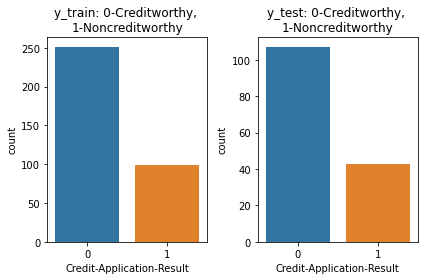

In [256]:
plt.subplot(1,2,1)
sns.countplot(y_train)
plt.title ('y_train: 0-Creditworthy, \n1-Noncreditworthy')

plt.subplot(1,2,2)
sns.countplot(y_test)
plt.title ('y_test: 0-Creditworthy, \n1-Noncreditworthy')
plt.tight_layout()

**The train and test data are still biased towards Creditworthy. This indicates that the model is likely to predict more of Creditworthy**

## Modeling 


- Naive Bayes
- Logistic Regression
- K-NearestNeighbors
- Support Vector Classifier

#### INITIAL COMPARISON OF MODELS WITHOUT PARAMETER TUNING

In [257]:
# This function takes a model and splitted data sets, train and test of X and y. It returns the model's score together 
# Fitting assessments (Overfitting or underfitting)

def models_no_tuning (model,X_train, X_test, y_train, y_test):
    from sklearn.preprocessing import StandardScaler
    
    if model == 'Naive Bayes':
        from sklearn.naive_bayes import GaussianNB
        
        typ = GaussianNB()
        # Fit the model
        model = typ
        clf = model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        print("Naive Bayes Model")
        print('-'*45)
        
    elif model == 'KNN':
            from sklearn.neighbors import KNeighborsClassifier
            knn = KNeighborsClassifier()
            knn.fit(X_train, y_train)
            train_score = knn.score(X_train, y_train) #Train score
            test_score = knn.score(X_test, y_test) #  Test score
            print("KNN Model")
            print('-'*45)            

    elif model == 'SVM':
        from sklearn.svm import LinearSVC
        
        sc_X = StandardScaler()
        X_train = sc_X.fit_transform(X_train)
        X_test = sc_X.transform(X_test)

        svc =  LinearSVC()
        svc.fit(X_train, y_train)
        train_score = svc.score(X_train, y_train)
        test_score = svc.score(X_test, y_test)
        print("SVM Model")
        print('-'*45)
        
    elif model == 'Logistic Regression':
        from sklearn.linear_model import LogisticRegression
        
        sc_X = StandardScaler()
        X_train = sc_X.fit_transform(X_train)
        X_test = sc_X.transform(X_test)

        logreg = LogisticRegression(solver='sag').fit(X_train, y_train)
        train_score = logreg.score(X_train, y_train)
        test_score = logreg.score(X_test, y_test)
        print("Logistic Regression Model")
        print('-'*45)
    
    #Print the scores of the requested model
    
    print("Training set score: {:.3f}".format(train_score))
    print("Test set score: {:.3f}".format(test_score))
    if train_score > test_score:
        print('Percentage of overfitting: {:.2f}%'.format((train_score-
                                         test_score)/train_score *100))
    elif test_score > train_score:
        print('Percentage of underfiting: {:.2f}%'.format((test_score-
                                         train_score)/test_score *100))
    print('='*45)


#### Comoparing Initial models without hyperparameter tuning

In [259]:
model_list = ['Naive Bayes','KNN','SVM','Logistic Regression']

for i in model_list:
    models_no_tuning (i,X_train, X_test, y_train, y_test)

Naive Bayes Model
---------------------------------------------
Training set score: 0.771
Test set score: 0.780
Percentage of underfiting: 1.10%
KNN Model
---------------------------------------------
Training set score: 0.771
Test set score: 0.687
Percentage of overfitting: 10.99%
SVM Model
---------------------------------------------
Training set score: 0.777
Test set score: 0.813
Percentage of underfiting: 4.45%
Logistic Regression Model
---------------------------------------------
Training set score: 0.786
Test set score: 0.800
Percentage of underfiting: 1.79%


# Finding Best Model (Hyperparameter tuning and GridSearch)

#### Generate Scores

In [260]:
#print scores of the model: cross-validation, train and test scores

def score_report_grid (grid, X_train, y_train, X_test, y_test,):
    
    #Print the scores of the model
    print('-'*40)
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Best Train score: {:.2f}".format(grid.score(X_train, y_train)))
    print("Best Test score: {:.2f}".format(grid.score(X_test, y_test)))

    if grid.score(X_train, y_train) > grid.score(X_test, y_test):
            print('Percentage of overfitting: {:.2f}%'.format((grid.score(X_train, y_train)-
                                             grid.score(X_test, y_test))/grid.score(X_train, y_train) *100))
    elif grid.score(X_test, y_test) > grid.score(X_train, y_train):
        print('Percentage of underfiting: {:.2f}%'.format((grid.score(X_test, y_test)-
                                         grid.score(X_train, y_train))/grid.score(X_test, y_test) *100), '\n')
    # Print best parameters
    print('-'*40)
    print('Best parameters:', grid.best_params_)
    print('='*40)

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    
#print scores of the model: train and test scores

def score_report (model, X_train, y_train, X_test, y_test,):
    
    #Print the scores of the model
    print('-'*40)
    print("Best Train score: {:.2f}".format(model.score(X_train, y_train)))
    print("Best Test score: {:.2f}".format(model.score(X_test, y_test)))

    if model.score(X_train, y_train) > model.score(X_test, y_test):
            print('Percentage of overfitting: {:.2f}%'.format((model.score(X_train, y_train)-
                                             model.score(X_test, y_test))/model.score(X_train, y_train) *100))
    elif model.score(X_test, y_test) > model.score(X_train, y_train):
        print('Percentage of underfiting: {:.2f}%'.format((model.score(X_test, y_test)-
                                         model.score(X_train, y_train))/model.score(X_test, y_test) *100), '\n')
    print('='*40)


### 1. Decision Tree -  (Cross-validation)

In [276]:
def tuned_dtree (X_train, y_train, X_test, y_test):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import accuracy_score
    dtree = DecisionTreeClassifier(random_state=41)

    param_grid = {'max_features': [1,2,3,4,5,6,7,8,9,10],
                  'max_leaf_nodes': [1,2,3,4,5,6,7,8,9,10],
                  }

    grid = GridSearchCV(dtree, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train) 
    
    #get final model
    dtr_model = grid.best_estimator_
    dtr_pred = dtr_model.predict(X_test)
    
    #return model scores and the final predicted values
    return score_report_grid (grid, X_train, y_train, X_test, y_test)

### 2. Logistic Regression - (Cross-validation)

In [277]:
def tuned_logistic_reg (X_train, y_train, X_test, y_test):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler

    pipe = Pipeline([('scaler', StandardScaler()),('loreg', LogisticRegression())])   # without scaling
    param_grid = {'loreg__C': [ 0.001,0.01, 0.1, 1, 10, 100]}

    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)
    
    #print scores of the model: cross-validation, train and test scores
    
    
    #get final model
    logreg_model = grid.best_estimator_
    logreg_pred = logreg_model.predict(X_test)
    
    #return model scores and the final predicted values   
    return score_report_grid (grid, X_train, y_train, X_test, y_test)

### 3. SVM - (Cross-validation)

In [278]:
def tuned_SVM (X_train, y_train, X_test, y_test):
    from sklearn.svm import LinearSVC
    # creating a pipe to scale the data for the SVM
    pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])
    param_grid = {'svm__C': [ 0.001,0.01, 0.1, 1, 10, 100],
                  'svm__gamma': [0.001,0.01, 0.1, 1, 10, 100]}
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)    
    
    #get final model
    svm_model = grid.best_estimator_
    svm_pred = svm_model.predict(X_test)

    #return model scores and the final predicted values       
    return score_report_grid (grid, X_train, y_train, X_test, y_test)

### 4. KNN- (Cross-validation)

In [279]:
def tuned_KNN (X_train, y_train, X_test, y_test):
    from sklearn.neighbors import KNeighborsClassifier

    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': [ 3,5,11,19],
                 'weights': ['uniform', 'distance'],
                 'metric': ['euclidean', 'manhattan']
                 }

    grid = GridSearchCV(knn, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)  
    
    #get final model
    knn_model = grid.best_estimator_
    knn_pred = knn_model.predict(X_test)
    
    #return model scores and the final predicted values
    return score_report_grid (grid, X_train, y_train, X_test, y_test)

### 5. NaiveBayes 

In [280]:
def naive_bayes (X_train, y_train, X_test, y_test):
    from sklearn.naive_bayes import GaussianNB

    typ = GaussianNB()
    # Fit the model
    model = typ
    model.fit(X_train, y_train)
    
    #get final model
    naive_pred = model.predict(X_test)
    
    #return model scores and the final predicted values
    return score_report (model, X_train, y_train, X_test, y_test)  

### 6. Random Forest- (Cross-validation)

In [281]:
def tuned_random_forest(X_train, y_train, X_test, y_test):
    from sklearn.ensemble import RandomForestClassifier
    # creating a pipe to scale the data for the RandomdomForest
    rf = RandomForestClassifier(random_state=41)

    param_grid = {
                'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                'max_leaf_nodes': [1,2,3,4,5,6,7,8,9,10]

                    }

    grid = GridSearchCV(rf, param_grid=param_grid, verbose =1, n_jobs =-1, cv=5)
    grid.fit(X_train, y_train)
    
    #get final model
    rf_model = grid.best_estimator_
    rf_pred = rf_model.predict(X_test)
    
    #return model scores and the final predicted values
    return score_report_grid (grid, X_train, y_train, X_test, y_test)   

### 7. Gradient Boosting- (Cross-validation)

In [350]:
def tuned_gradient_boosting(X_train, y_train, X_test, y_test):
    from sklearn.ensemble import GradientBoostingClassifier
    gbc = GradientBoostingClassifier(n_estimators=300, max_depth=1, random_state=41)
    param_grid = {
                 'max_leaf_nodes': [1,2,3,4,5,6,7,8,9,10]
                 }

    grid = GridSearchCV(gbc, param_grid=param_grid, verbose =1, n_jobs =-1, cv=5)
    grid.fit(X_train, y_train)
    
    #get final model
    gbc_model = grid.best_estimator_
    gbc_pred = gbc_model.predict(X_test)

    #return model scores and the final predicted values
    return score_report_grid (grid, X_train, y_train, X_test, y_test)   

### 8. AdaBoost (No need for parameter tuning)

In [351]:
def adaboos(X_train, y_train, X_test, y_test):
    from sklearn.ensemble import AdaBoostClassifier
    #Instantiate DecisionTree
    dtr = DecisionTreeClassifier(max_depth=1, max_features=5, max_leaf_nodes=10, random_state=41)

    #AdaboostClassifier
    adc = AdaBoostClassifier(base_estimator=dtr, n_estimators=80, random_state=41)
    #fit AdaBoost
    adc.fit(X_train,y_train)
    
    #get final model
    adcl_pred = adc.predict(X_test)
    
    #return model scores and the final predicted values
    return score_report (adc, X_train, y_train, X_test, y_test)   

## Get the Scores of all the 8 models and store their predicted y 


In [352]:

def all_models (X_train, y_train, X_test, y_test):
    #prints model scores 
    
    print('1. DecisionTree:')
    tuned_dtree (X_train, y_train, X_test, y_test) 
    
    print('2. LogisticRegression:')
    logreg_pred = tuned_logistic_reg (X_train, y_train, X_test, y_test)
    
    print('3. SVM:')    
    svm_pred = tuned_SVM (X_train, y_train, X_test, y_test)
    
    print('4. KNN:')
    knn_pred = tuned_KNN (X_train, y_train, X_test, y_test) 
    
    print('5. NaiveBayes:')    
    naive_pred = naive_bayes (X_train, y_train, X_test, y_test)
    
    print('6. RandomForest:')    
    rf_pred = tuned_random_forest(X_train, y_train, X_test, y_test) 
    
    print('7. GradientBoosting:')    
    gbc_pred = tuned_gradient_boosting(X_train, y_train, X_test, y_test) 
    
    print('8. AdaBoost:')    
    adcl_pred = adaboos(X_train, y_train, X_test, y_test)

In [353]:
all_models (X_train, y_train, X_test, y_test)

1. DecisionTree:
----------------------------------------
Best cross-validation score: 0.76
Best Train score: 0.79
Best Test score: 0.73
Percentage of overfitting: 7.00%
----------------------------------------
Best parameters: {'max_features': 8, 'max_leaf_nodes': 6}
2. LogisticRegression:
----------------------------------------
Best cross-validation score: 0.76
Best Train score: 0.79
Best Test score: 0.80
Percentage of underfiting: 1.79% 

----------------------------------------
Best parameters: {'loreg__C': 1}
3. SVM:
----------------------------------------
Best cross-validation score: 0.78
Best Train score: 0.83
Best Test score: 0.77
Percentage of overfitting: 7.79%
----------------------------------------
Best parameters: {'svm__C': 10, 'svm__gamma': 0.01}
4. KNN:
----------------------------------------
Best cross-validation score: 0.73
Best Train score: 0.75
Best Test score: 0.71
Percentage of overfitting: 5.96%
----------------------------------------
Best parameters: {'metr

# Selection of Best features 
**- Idendity important Features**

Text(0.5, 1.0, 'Feature Importance in Random Forest')

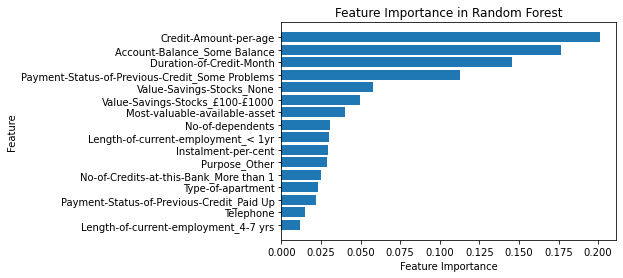

In [286]:
# Feature importance in Random Forest, and Decision Tree  

feature_name = train.columns[train.columns!='Credit-Application-Result']
classifier_name = train.columns[train.columns=='Credit-Application-Result']

#Random Forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_features=2, max_leaf_nodes=7, n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
df_rf = pd.DataFrame({'feature':list(feature_name),'importance': forest.feature_importances_}).sort_values('importance')
# plt.barh(list(df_rf.feature), df_rf['importance'])


plt.figsize=(15, 5)


plt.barh(list(df_rf.feature), df_rf['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')


**- Select Important Features by Recursive Feature Elimination (RFE)**

In [308]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1))
rfe.fit(X_train, y_train)


RFE(estimator=RandomForestClassifier(n_jobs=-1))

In [309]:
rfe.support_

array([ True,  True,  True,  True, False, False,  True, False,  True,
       False,  True, False, False, False, False,  True])

In [310]:
len(X.columns)

16

In [311]:
len(X.columns[rfe.support_])

8

In [312]:
#Mean of feature importances
#Values below this mean are considered unimportant

np.mean(rfe.estimator_.feature_importances_)

0.125

#### - Final important features selected by RFE

In [313]:
columns=[]
rank=[]          
for i, j in zip(X.columns[rfe.support_], rfe.ranking_):
    columns.append(i), rank.append(j)
di = {'Feature': columns,
     'rank': rank}    
df_rank_columns = pd.DataFrame(di) # Create a data frame that will contain
                                   # Important features and their rank
df_rank_columns.set_index('Feature').sort_values('rank')

,rank
Feature,
Duration-of-Credit-Month,1
Instalment-per-cent,1
Most-valuable-available-asset,1
Type-of-apartment,1
Value-Savings-Stocks_None,1
Payment-Status-of-Previous-Credit_Some Problems,2
Account-Balance_Some Balance,5
Credit-Amount-per-age,6


- All those features ranked 1 are the ones that strongly predict the label 
- The 6th ranked feature 'Payment-Status-of-Previous-Credit_Some Problems', is the last important feature maintained.

### Determine the Performance of RandomForest using new training and testing data sets with reduced features
1. Get new train and test data sets with the new features 

In [314]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [315]:
X_train_rfe.shape, X_test_rfe.shape

((350, 8), (150, 8))

2. Compare the RandomForest, Before and After 

In [332]:
# Define a random forest model using the optimised parameters
def rf_tuned_parameters(X_train, y_train, X_test, y_test):
    rfc = RandomForestClassifier(max_leaf_nodes=9, n_estimators=80, random_state = 41, n_jobs=-1)
    rfc.fit(X_train,y_train)
    rf_pred = rfc.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test,rf_pred))
    

In [333]:
#Beofre feature reduction

In [334]:
%%time
rf_tuned_parameters(X_train, y_train, X_test, y_test)

Accuracy:  0.74
Wall time: 244 ms


In [335]:
#After feature reduction using RFE

In [336]:
%%time    
rf_tuned_parameters(X_train_rfe, y_train, X_test_rfe, y_test)

Accuracy:  0.7933333333333333
Wall time: 238 ms


In [337]:
tuned_random_forest(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------------------------------------
Best cross-validation score: 0.78
Best Train score: 0.81
Best Test score: 0.77
Percentage of overfitting: 4.36%
----------------------------------------
Best parameters: {'max_features': 8, 'max_leaf_nodes': 9}


- **The RFE returned better accuracy (0.793) than the tuned RandomForest (0.77) and Full features (0.74)**
- **Both RFE and tuned RandomForest returned 8 max_features**

3. feature Selection by GradientBoost

In [338]:
from sklearn.ensemble import GradientBoostingClassifier

In [339]:
from sklearn.feature_selection import RFE
rfe_gbc = RFE(estimator=GradientBoostingClassifier(n_estimators=100, random_state=0))
rfe_gbc.fit(X_train, y_train)


RFE(estimator=GradientBoostingClassifier(random_state=0))

In [340]:
rfe_gbc.support_

array([ True, False, False, False,  True,  True,  True, False,  True,
       False,  True,  True, False, False, False,  True])

In [341]:
len(X.columns)

16

In [342]:
len(X.columns[rfe_gbc.support_])

8

In [344]:
X_train_rfe = rfe_gbc.transform(X_train)
X_test_rfe = rfe_gbc.transform(X_test)

In [345]:
#Beofre feature reduction

In [346]:
%%time
rf_tuned_parameters(X_train, y_train, X_test, y_test)

Accuracy:  0.74
Wall time: 240 ms


In [347]:
#After feature reduction using RFE and GradientBoosting

In [348]:
%%time    
rf_tuned_parameters(X_train_rfe, y_train, X_test_rfe, y_test)

Accuracy:  0.7333333333333333
Wall time: 232 ms


- **The RFE using RandomForest (07933) performs better than RFE using gradientBoosting (0.733), both using max_leaf of 8

In [349]:
#Using for loop to select the number of features while 
#racking model accuracy

In [385]:
from sklearn.feature_selection import RFE
rfe = RFE (estimator=RandomForestClassifier(max_features=10,
                                           max_leaf_nodes=7,
                                           max_depth=3),
          n_features_to_select=18, verbose=1)
rfe.fit(X_train,y_train)



train_score = rfe.score(X_train, y_train)
test_score = rfe.score(X_test, y_test)

#Print the scores of the model
print("RFE")
print('-'*40)
print("Training accuracy: {:.3f}".format(train_score))
print("Test accuracy: {:.3f}".format(test_score))
if train_score > test_score:
    print('Percentage of overfitting: {:.2f}%'.format((train_score-
                                     test_score)/train_score *100))
elif test_score > train_score:
    print('Percentage of underfiting: {:.2f}%'.format((test_score-
                                     train_score)/test_score *100))
print('='*40)



RFE
----------------------------------------
Training accuracy: 0.803
Test accuracy: 0.753
Percentage of overfitting: 6.17%


# Dealing with the unbalanced target variable

In [78]:
from imblearn.over_sampling import SMOTE
ovs = SMOTE(random_state=0)
smote_X_train, smote_y_train = ovs.fit_resample(X_train, y_train)

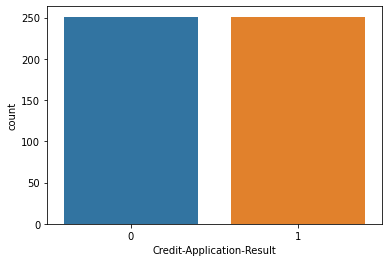

In [79]:
sns.countplot(smote_y_train)
plt.show()

In [80]:
# 1. Decision Tree

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import os, json, codecs, nltk  
from time import time 

dtree = DecisionTreeClassifier(random_state=41)

param_grid = {'max_features': [1,2,3,4,5,6,7,8,9,10],
              'max_leaf_nodes': [1,2,3,4,5,6,7,8,9,10],
              }

grid = GridSearchCV(dtree, param_grid=param_grid, cv=5)
grid.fit(smote_X_train, smote_y_train)

#Print the scores of the model
print("Decision Tree - balanced data (cross validated)")
print('-'*40)
print("done in {0}s".format(time()), '\n')  
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

print("Best Train score: {:.2f}".format(grid.score(smote_X_train, smote_y_train)))
print("Best Test score: {:.2f}".format(grid.score(X_test, y_test)))

if grid.score(smote_X_train, smote_y_train) > grid.score(X_test, y_test):
        print('Percentage of overfitting: {:.2f}%'.format((grid.score(smote_X_train, smote_y_train)-
                                         grid.score(X_test, y_test))/grid.score(smote_X_train, smote_y_train) *100))
elif grid.score(X_test, y_test) > grid.score(smote_X_train, smote_y_train):
    print('Percentage of underfiting: {:.2f}%'.format((grid.score(X_test, y_test)-
                                     grid.score(smote_X_train, smote_y_train))/grid.score(X_test, y_test) *100), '\n')
# Print best parameters
print('-'*40)
print('Best parameters:', grid.best_params_)
print('='*40)

Decision Tree - balanced data (cross validated)
----------------------------------------
done in 1637656038.2429664s 

Best cross-validation score: 0.76
Best Train score: 0.76
Best Test score: 0.67
Percentage of overfitting: 11.93%
----------------------------------------
Best parameters: {'max_features': 10, 'max_leaf_nodes': 3}


In [82]:
dtr_model = grid.best_estimator_
dtr_pred = dtr_model.predict(X_train)

In [83]:
# 2. Logistic Regression

In [84]:
pipe = Pipeline([('loreg', LogisticRegression())])   # without scaling
param_grid = {'loreg__C': [ 0.001,0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(smote_X_train, smote_y_train)

#Print the scores of the model
print("Logistic Regression - Balanced data (cross validated)")
print('-'*40)
print("done in {0}s".format(time()), '\n')  
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

print("Best Train score: {:.2f}".format(grid.score(smote_X_train, smote_y_train)))
print("Best Test score: {:.2f}".format(grid.score(X_test, y_test)))

if grid.score(smote_X_train, smote_y_train) > grid.score(X_test, y_test):
        print('Percentage of overfitting: {:.2f}%'.format((grid.score(smote_X_train, smote_y_train)-
                                         grid.score(X_test, y_test))/grid.score(smote_X_train, smote_y_train) *100))
elif grid.score(X_test, y_test) > grid.score(smote_X_train, smote_y_train):
    print('Percentage of underfiting: {:.2f}%'.format((grid.score(X_test, y_test)-
                                     grid.score(smote_X_train, smote_y_train))/grid.score(X_test, y_test) *100), '\n')
# Print best parameters
print('-'*40)
print('Best parameters:', grid.best_params_)
print('='*40)

Logistic Regression - Balanced data (cross validated)
----------------------------------------
done in 1637656041.2078626s 

Best cross-validation score: 0.75
Best Train score: 0.76
Best Test score: 0.71
Percentage of overfitting: 7.38%
----------------------------------------
Best parameters: {'loreg__C': 1}


In [85]:
logreg_model = grid.best_estimator_
logreg_pred = logreg_model.predict(X_train)

In [86]:
#3. SVM

In [87]:
# creating a pipe to scale the data for the SVM

pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])
param_grid = {'svm__C': [ 0.001,0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001,0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(smote_X_train, smote_y_train)

#Print the scores of the model
print("SVM - Balanced Data (cross validated)")
print('-'*40)
print("done in {0}s".format(time()), '\n')  
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

print("Best Train score: {:.2f}".format(grid.score(smote_X_train, smote_y_train)))
print("Best Test score: {:.2f}".format(grid.score(X_test, y_test)))

if grid.score(smote_X_train, smote_y_train) > grid.score(X_test, y_test):
        print('Percentage of overfitting: {:.2f}%'.format((grid.score(smote_X_train, smote_y_train)-
                                         grid.score(X_test, y_test))/grid.score(smote_X_train, smote_y_train) *100))
elif grid.score(X_test, y_test) > grid.score(smote_X_train, smote_y_train):
    print('Percentage of underfiting: {:.2f}%'.format((grid.score(X_test, y_test)-
                                     grid.score(smote_X_train, smote_y_train))/grid.score(X_test, y_test) *100), '\n')
# Print best parameters
print('-'*40)
print('Best parameters:', grid.best_params_)
print('='*40)

SVM - Balanced Data (cross validated)
----------------------------------------
done in 1637656883.9313803s 

Best cross-validation score: 0.81
Best Train score: 0.92
Best Test score: 0.73
Percentage of overfitting: 21.04%
----------------------------------------
Best parameters: {'svm__C': 1, 'svm__gamma': 0.1}


In [91]:
svm_model = grid.best_estimator_
svm_pred = svm_model.predict(X_train)

In [92]:
#4. KNN

In [93]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [ 3,5,11,19],
             'weights': ['uniform', 'distance'],
             'metric': ['euclidean', 'manhattan']
             }

grid = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid.fit(smote_X_train, smote_y_train)

#Print the scores of the model
print("KNN - Balanced Data (cross validated)")
print('-'*40)
print("done in {0}s".format(time()), '\n')  
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

print("Best Train score: {:.2f}".format(grid.score(smote_X_train, smote_y_train)))
print("Best Test score: {:.2f}".format(grid.score(X_test, y_test)))

if grid.score(smote_X_train, smote_y_train) > grid.score(X_test, y_test):
        print('Percentage of overfitting: {:.2f}%'.format((grid.score(smote_X_train, smote_y_train)-
                                         grid.score(X_test, y_test))/grid.score(smote_X_train, smote_y_train) *100))
elif grid.score(X_test, y_test) > grid.score(smote_X_train, smote_y_train):
    print('Percentage of underfiting: {:.2f}%'.format((grid.score(X_test, y_test)-
                                     grid.score(smote_X_train, smote_y_train))/grid.score(X_test, y_test) *100), '\n')
# Print best parameters
print('-'*40)
print('Best parameters:', grid.best_params_)
print('='*40)

KNN - Balanced Data (cross validated)
----------------------------------------
done in 1637656917.0095508s 

Best cross-validation score: 0.68
Best Train score: 1.00
Best Test score: 0.61
Percentage of overfitting: 38.67%
----------------------------------------
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


In [94]:
knn_model = grid.best_estimator_
knn_pred = knn_model.predict(X_train)

In [95]:
#4. Random Forest

In [96]:
# creating a pipe to scale the data for the RandomdomForest
rf = RandomForestClassifier(random_state=41)

param_grid = {
            'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'max_depth': [1,2,3,4,5,6,7,8,9,10],
            'max_leaf_nodes': [1,2,3,4,5,6,7,8,9,10]

                }
                                            
grid = GridSearchCV(rf, param_grid=param_grid, verbose =1, n_jobs =-1, cv=5)
grid.fit(smote_X_train, smote_y_train)

#Print the scores of the model
print("Random Forest - Balanced Data (cross validated)")
print('-'*40)
print("done in {0}s".format(time()), '\n')  
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

print("Best Train score: {:.2f}".format(grid.score(smote_X_train, smote_y_train)))
print("Best Test score: {:.2f}".format(grid.score(X_test, y_test)))

if grid.score(smote_X_train, smote_y_train) > grid.score(X_test, y_test):
        print('Percentage of overfitting: {:.2f}%'.format((grid.score(smote_X_train, smote_y_train)-
                                         grid.score(X_test, y_test))/grid.score(smote_X_train, smote_y_train) *100))
elif grid.score(X_test, y_test) > grid.score(smote_X_train, smote_y_train):
    print('Percentage of underfiting: {:.2f}%'.format((grid.score(X_test, y_test)-
                                     grid.score(smote_X_train, smote_y_train))/grid.score(X_test, y_test) *100), '\n')
# Print best parameters
print('-'*40)
print('Best parameters:', grid.best_params_)
print('='*40)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Random Forest - Balanced Data (cross validated)
----------------------------------------
done in 1637657493.0298934s 

Best cross-validation score: 0.80
Best Train score: 0.83
Best Test score: 0.72
Percentage of overfitting: 13.53%
----------------------------------------
Best parameters: {'max_depth': 6, 'max_features': 2, 'max_leaf_nodes': 7}


In [98]:
rf_model = grid.best_estimator_
rf_pred = rf_model.predict(X_train)

In [99]:
#5. Voting Classifier

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN


In [101]:
#Inastantiating individual Classifiers

logr = LogisticRegression(random_state=41, C=1)
svc = SVC(C=1, gamma=0.1)
dtr = DecisionTreeClassifier(max_features=10, max_leaf_nodes=3, random_state=41)


classiifiers = [('logistic Regression', logr), ('SVC', svc), ('Decision Tree', dtr)]

In [102]:
#Iterating over the classifiers list

for i, j in classiifiers:
    j.fit(smote_X_train, smote_y_train)
    
    #predict labels
    y_pred = j.predict(X_test)
    
    #Accuracy
    print('{}: {:.3f}'.format(i, accuracy_score(y_test,y_pred)))

logistic Regression: 0.707
SVC: 0.727
Decision Tree: 0.667


In [103]:
#Voting Classifier

vc = VotingClassifier(estimators=classiifiers)
vc.fit(smote_X_train, smote_y_train)
y_pred = vc.predict(X_test)

#Train and Test Accuracy of Voting Classifier
train_score = vc.score(smote_X_train, smote_y_train)
test_score = accuracy_score(y_test, y_pred)

#Print the scores of the model
print('Voting Classifier train score: {:.3f}'.format(train_score))
print('Voting Classifier test score: {:.3f}'.format(test_score))

print('-'*40)

if train_score > test_score:
    print('Percentage of overfitting: {:.2f}%'.format((train_score-
                                     test_score)/train_score *100))
elif test_score > train_score:
    print('Percentage of underfiting: {:.2f}%'.format((test_score-
                                     train_score)/test_score *100))
print('='*40)



Voting Classifier train score: 0.815
Voting Classifier test score: 0.700
----------------------------------------
Percentage of overfitting: 14.08%


# Bagging

In [104]:
from sklearn.ensemble import BaggingClassifier

In [105]:
rfc = RandomForestClassifier(random_state=0, max_features=2, max_depth=4, max_leaf_nodes=7)
bc = BaggingClassifier(base_estimator=rfc, n_estimators=80, n_jobs=-1)

bc.fit(smote_X_train, smote_y_train)

y_pred = bc.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
train_score = bc.score(smote_X_train, smote_y_train)
test_score = bc.score(X_test, y_test)


print('Accuracy of Bagging Classifier: {}'.format(acc_score))

print("Training accuracy: {:.3f}".format(train_score))
print("Test accuracy: {:.3f}".format(test_score))
if train_score > test_score:
    print('Percentage of overfitting: {:.2f}%'.format((train_score-
                                     test_score)/train_score *100))
elif test_score > train_score:
    print('Percentage of underfiting: {:.2f}%'.format((test_score-
                                     train_score)/test_score *100))
print('='*40)


Accuracy of Bagging Classifier: 0.72
Training accuracy: 0.831
Test accuracy: 0.720
Percentage of overfitting: 13.32%


In [106]:
# AdaBoost

In [107]:
#Instantiate DecisionTree
dtr = DecisionTreeClassifier(max_depth=1, max_features=10, max_leaf_nodes=3, random_state=41)

#AdaboostClassifier
adcl = AdaBoostClassifier(base_estimator=dtr, n_estimators=80, random_state=41)
#fit AdaBoost
adcl.fit(smote_X_train, smote_y_train)

train_score = adcl.score(smote_X_train, smote_y_train)
test_score = adcl.score(X_test, y_test)

#Print the scores of the model
print("AdaBoost - Balanced Data")
print('-'*40)
print("Training accuracy: {:.3f}".format(train_score))
print("Test accuracy: {:.3f}".format(test_score))
if train_score > test_score:
    print('Percentage of overfitting: {:.2f}%'.format((train_score-
                                     test_score)/train_score *100))
elif test_score > train_score:
    print('Percentage of underfiting: {:.2f}%'.format((test_score-
                                     train_score)/test_score *100))
print('='*40)



AdaBoost - Balanced Data
----------------------------------------
Training accuracy: 0.869
Test accuracy: 0.707
Percentage of overfitting: 18.64%


In [108]:
# Gradient Boosting

In [109]:
gbc = GradientBoostingClassifier(n_estimators=300,max_features=1, max_depth=1, random_state=41)
gbc.fit(smote_X_train, smote_y_train)

y_pred = gbc.predict(X_test)
train_score = gbc.score(smote_X_train, smote_y_train)
test_score = gbc.score(X_test, y_test)

#Print the scores of the model
print("GradientBoost - Balanced Data")
print('-'*40)
print("Training accuracy: {:.3f}".format(train_score))
print("Test accuracy: {:.3f}".format(test_score))
if train_score > test_score:
    print('Percentage of overfitting: {:.2f}%'.format((train_score-
                                     test_score)/train_score *100))
elif test_score > train_score:
    print('Percentage of underfiting: {:.2f}%'.format((test_score-
                                     train_score)/test_score *100))
print('='*40)


GradientBoost - Balanced Data
----------------------------------------
Training accuracy: 0.827
Test accuracy: 0.700
Percentage of overfitting: 15.33%


## Feature Importance

Text(0.5, 1.0, 'Feature Importance in Random Forest')

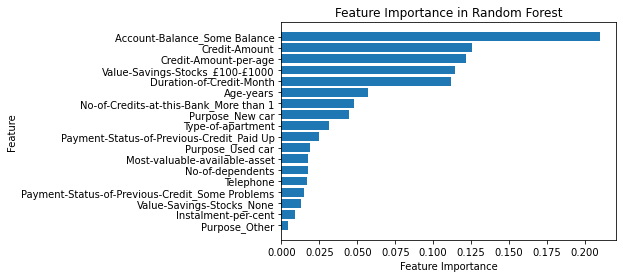

In [113]:
# Feature importance in Random Forest, and Decision Tree  

feature_name = train.columns[train.columns!='Credit-Application-Result']
classifier_name = train.columns[train.columns=='Credit-Application-Result']

#Random Forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_features=2, max_leaf_nodes=7, n_estimators=100, random_state=0)
forest.fit(smote_X_train, smote_y_train)
df_rf = pd.DataFrame({'feature':list(feature_name),'importance': forest.feature_importances_}).sort_values('importance')
# plt.barh(list(df_rf.feature), df_rf['importance'])


plt.figsize=(15, 5)


plt.barh(list(df_rf.feature), df_rf['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')



### Recursive feature Elimination

In [114]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestClassifier(max_features=2, max_leaf_nodes=7))
rfe.fit(smote_X_train, smote_y_train)

RFE(estimator=RandomForestClassifier(max_features=2, max_leaf_nodes=7))

In [115]:
rfe.support_

array([ True,  True, False, False,  True,  True, False, False,  True,
       False, False,  True, False, False, False,  True,  True,  True])

In [116]:
X.columns[rfe.support_]

Index(['Duration-of-Credit-Month', 'Credit-Amount', 'Age-years',
       'Type-of-apartment', 'Account-Balance_Some Balance', 'Purpose_New car',
       'Value-Savings-Stocks_£100-£1000',
       'No-of-Credits-at-this-Bank_More than 1', 'Credit-Amount-per-age'],
      dtype='object')

In [157]:
columns=[]
rank=[]          
for i, j in zip(X.columns, rfe.ranking_):
    columns.append(i), rank.append(j)
di = {'Feature': columns,
     'rank': rank}    
df_rank_columns = pd.DataFrame(di)
df_rank_columns.set_index('Feature').sort_values('rank'

,rank
Feature,
Duration-of-Credit-Month,1
Value-Savings-Stocks_£100-£1000,1
Purpose_New car,1
No-of-Credits-at-this-Bank_More than 1,1
Type-of-apartment,1
Account-Balance_Some Balance,1
Credit-Amount,1
Age-years,1
Credit-Amount-per-age,1


In [118]:
#Scores
y_pred = rfe.predict(X_test)

train_score =  rfe.score(smote_X_train, smote_y_train)
test_score = accuracy_score(y_test, y_pred)

#Print the scores of the model
print('-'*40)
print("RFE Train accuracy: {:.3f}".format(train_score))
print("RFE Test accuracy: {:.3f}".format(test_score))
if train_score > test_score:
    print('Percentage of overfitting: {:.2f}%'.format((train_score-
                                     test_score)/train_score *100))
elif test_score > train_score:
    print('Percentage of underfiting: {:.2f}%'.format((test_score-
                                     train_score)/test_score *100))
print('='*40)


----------------------------------------
RFE Train accuracy: 0.817
RFE Test accuracy: 0.700
Percentage of overfitting: 14.29%


### Evaluation Metrics and Scoring of models Using the optimised Hyperparameters 

# A. Confusion Metrix

**1. Confusion Metrix for unbalanced data**

In [129]:
# KNN

knn1_pred = knn_model1.predict(X_test)
                 
#"""""""""""""""""""""""""""""""""""""""""""""""      
# SVM
svm1_pred = svm_model1.predict(X_test)

#"""""""""""""""""""""""""""""""""""""""""""""""   
# Logistic Regression
logreg1_pred = logreg_model1.predict(X_test)

#"""""""""""""""""""""""""""""""""""""""""""""""          
#RandomForest
rf1_pred = rf_model1.predict(X_test)

#"""""""""""""""""""""""""""""""""""""""""""""""
# GradientBoosting
gbc1_pred = gbc_model1.predict(X_test)

#"""""""""""""""""""""""""""""""""""""""""""""""
# AdaBoost
adcl1_pred = adc_l.predict(X_test)

In [130]:
#Confusion matrices
from sklearn.metrics import confusion_matrix

print("KNN:")
print(confusion_matrix(y_test, knn1_pred))
print("SVM:")
print(confusion_matrix(y_test, svm1_pred))
print("\nLogistic Regression")
print(confusion_matrix(y_test, logreg1_pred))
print("\nRandom Forest:")
print(confusion_matrix(y_test, rf1_pred))
print("\nGradientBoosting:")
print(confusion_matrix(y_test, gbc1_pred))
print("\nAdaBoost:")
print(confusion_matrix(y_test, adcl1_pred))


KNN:
[[106   1]
 [ 40   3]]
SVM:
[[102   5]
 [ 28  15]]

Logistic Regression
[[92 15]
 [24 19]]

Random Forest:
[[103   4]
 [ 33  10]]

GradientBoosting:
[[93 14]
 [26 17]]

AdaBoost:
[[86 21]
 [22 21]]


**2. Confusion Metrix for Balanced Data**

In [135]:
# KNN

knn_pred = knn_model.predict(X_test)
                 
#"""""""""""""""""""""""""""""""""""""""""""""""      
# SVM
svm_pred = svm_model.predict(X_test)

#"""""""""""""""""""""""""""""""""""""""""""""""   
# Logistic Regression
logreg_pred = logreg_model.predict(X_test)

#"""""""""""""""""""""""""""""""""""""""""""""""          
#RandomForest
rf_pred = rf_model.predict(X_test)

#"""""""""""""""""""""""""""""""""""""""""""""""
# RFE
rfe_pred = rfe.predict(X_test)

#"""""""""""""""""""""""""""""""""""""""""""""""
# GradientBoosting
gbc_pred = gbc.predict(X_test)

#"""""""""""""""""""""""""""""""""""""""""""""""
# AdaBoost
adcl_pred = adcl.predict(X_test)

#"""""""""""""""""""""""""""""""""""""""""""""""
# Bagging
bc_pred = bc.predict(X_test)

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
# VotingClassifier
vc_pred = vc.predict(X_test)

In [136]:
#Confusion matrices
from sklearn.metrics import confusion_matrix

print("KNN:")
print(confusion_matrix(y_test, knn_pred))
print("SVM:")
print(confusion_matrix(y_test, svm_pred))
print("\nLogistic Regression")
print(confusion_matrix(y_test, logreg_pred))
print("\nRandom Forest:")
print(confusion_matrix(y_test, rf_pred))
print("\nRFE:")
print(confusion_matrix(y_test, rfe_pred))
print("\nGradientBoosting:")
print(confusion_matrix(y_test, gbc_pred))
print("\nAdaBoost:")
print(confusion_matrix(y_test, adcl_pred))
print("\nBagging:")
print(confusion_matrix(y_test, bc_pred))
print("\nVotingClassifier:")
print(confusion_matrix(y_test, vc_pred))

KNN:
[[72 35]
 [23 20]]
SVM:
[[72 35]
 [23 20]]

Logistic Regression
[[80 27]
 [17 26]]

Random Forest:
[[84 23]
 [19 24]]

RFE:
[[78 29]
 [16 27]]

GradientBoosting:
[[80 27]
 [18 25]]

AdaBoost:
[[81 26]
 [18 25]]

Bagging:
[[84 23]
 [19 24]]

VotingClassifier:
[[81 26]
 [19 24]]


# B. F-Score

**1. F-Score for Unbalanced data**

In [137]:
# f-score
from sklearn.metrics import f1_score

print("f1 score (KNN): {:.2f}".format(f1_score(y_test, knn1_pred)))
print("f1 score (SVM): {:.2f}".format(f1_score(y_test, svm1_pred)))
print("f1 score (Logistic Regression): {:.2f}".format(
f1_score(y_test, logreg1_pred)))
print("f1 score (Random Forest): {:.2f}".format(f1_score(y_test, rf1_pred)))
print("f1 score (GradientBoosting): {:.2f}".format(f1_score(y_test, gbc1_pred)))
print("f1 score (AdaBoost): {:.2f}".format(f1_score(y_test, adcl1_pred)))



f1 score (KNN): 0.13
f1 score (SVM): 0.48
f1 score (Logistic Regression): 0.49
f1 score (Random Forest): 0.35
f1 score (GradientBoosting): 0.46
f1 score (AdaBoost): 0.49


**2. F-Score for Balanced data**

In [139]:
# f-score
from sklearn.metrics import f1_score

print("f1 score (KNN): {:.2f}".format(f1_score(y_test, knn_pred)))
print("f1 score (SVM): {:.2f}".format(f1_score(y_test, svm_pred)))
print("f1 score (Logistic Regression): {:.2f}".format(
f1_score(y_test, logreg_pred)))
print("f1 score (Random Forest): {:.2f}".format(f1_score(y_test, rf_pred)))
print("f1 score (RFE): {:.2f}".format(f1_score(y_test, rfe_pred)))

print("f1 score (GradientBoosting): {:.2f}".format(f1_score(y_test, gbc_pred)))
print("f1 score (AdaBoost): {:.2f}".format(f1_score(y_test, adcl_pred)))
print("f1 score (Bagging): {:.2f}".format(f1_score(y_test, bc_pred)))
print("f1 score (VotingClassifier): {:.2f}".format(f1_score(y_test, vc_pred)))


f1 score (KNN): 0.41
f1 score (SVM): 0.41
f1 score (Logistic Regression): 0.54
f1 score (Random Forest): 0.53
f1 score (RFE): 0.55
f1 score (GradientBoosting): 0.53
f1 score (AdaBoost): 0.53
f1 score (Bagging): 0.53
f1 score (VotingClassifier): 0.52


In [ ]:
# Classification Report

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report
print("SVM:\n",cr(y_test, pred_svm,
target_names=["Creditworthy", "Non-Creditworthy"]),"-"*65,'\n\n')
print("Random Forest:\n",cr(y_test, pred_forest,
target_names=["Creditworthy", "Non-Creditworthy"]),"-"*65,'\n\n')
print("logistic regression:\n",cr(y_test, pred_logreg,
target_names=["Creditworthy", "Non-Creditworthy"]),"-"*65,'\n\n')

# PREDICTION OF CUSTOMERS CREDIT WORTHINESS TO QUALIFY FOR LOANS